# Step 1: Install Required Libraries

In [1]:
# !pip install python-binance pandas numpy matplotlib seaborn scipy scikit-learn 

# Step 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from binance.client import Client
from datetime import datetime
from scipy.stats import ttest_1samp
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator

# Step 3: Set Plotting Theme


In [3]:
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.2)
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

# Step 4: Fetch Data from Binance

In [4]:
# Initialize Binance client
api_key = 'YOUR_API_KEY'
api_secret = 'YOUR_SECRET_KEY'
client = Client(api_key, api_secret)

# Fetch data
symbol = 'ETHUSDT'
interval = '1h'
start_date = '2023-01-01'
end_date = '2025-01-01'

# Convert dates to timestamps
start_ts = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)
end_ts = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)

# Fetch klines and convert to DataFrame
klines = client.get_historical_klines(symbol, interval, start_ts, end_ts)
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 
           'num_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore']
df = pd.DataFrame(klines, columns=columns)

# Clean and format data
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df['close'] = df['close'].astype(float)
df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
df.set_index('timestamp', inplace=True)

# Step 5: Define the Strategy and Calculate Overall Backtest Results

=== Overall Backtest Results ===
Total Trades: 112.0
Annualized Return: -23.36%
Max Drawdown: 58.33%
Sharpe Ratio: -0.20
Sortino Ratio: -0.26




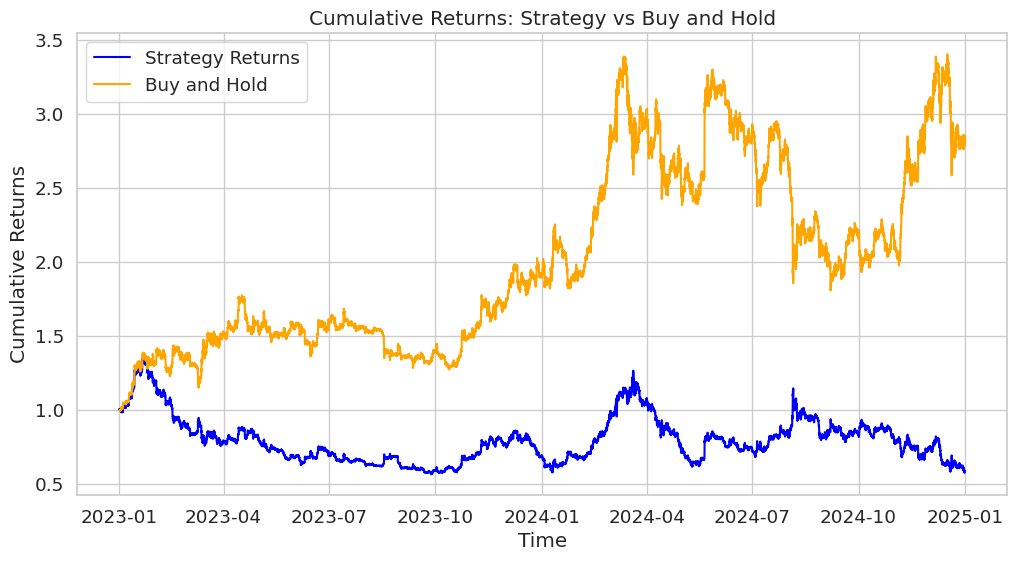

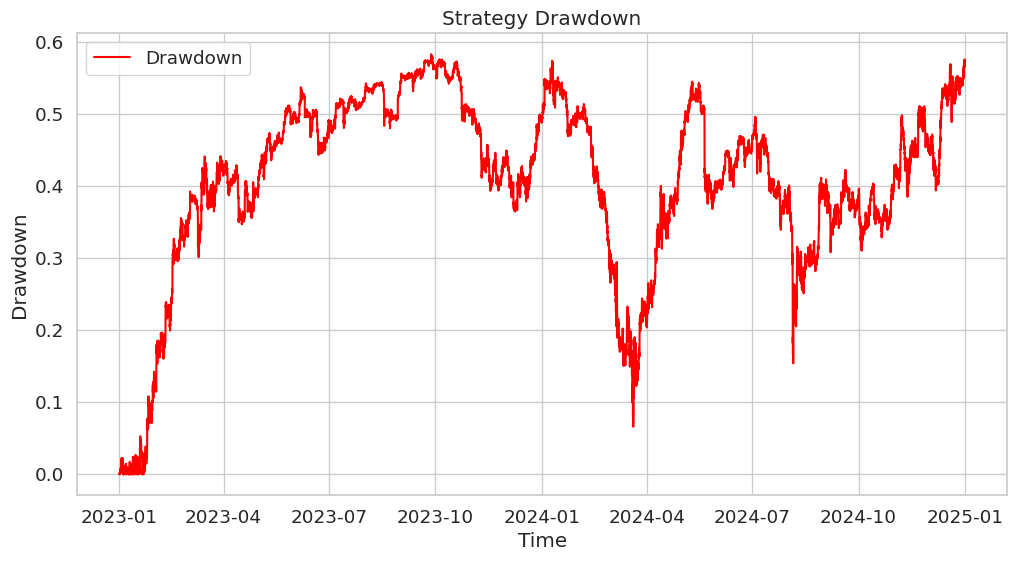

In [5]:
# Calculate moving averages
df['SMA_50'] = df['close'].rolling(window=50, min_periods=1).mean()
df['SMA_200'] = df['close'].rolling(window=200, min_periods=1).mean()

# Generate signals
df['signal'] = np.where(df['SMA_50'] > df['SMA_200'], 1, -1)

# Ensure signals are shifted to avoid look-ahead bias
df['signal'] = df['signal'].shift(1)

# Calculate strategy returns
df['returns'] = df['close'].pct_change()
df['strategy_returns'] = df['signal'] * df['returns']

# Calculate cumulative returns
df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()

# Calculate key metrics
# --- Total Trades ---
# Count only actual trades (ignoring neutral positions)
df['trade'] = df['signal'].diff().fillna(0).abs()
total_trades = df['trade'].sum() / 2  # Divide by 2 to count only entry/exit pairs

# --- Annualized Return ---
total_return = df['cumulative_returns'].iloc[-1] - 1  # Total return over the entire period
annualized_return = (1 + total_return) ** (365 * 24 / len(df)) - 1  # Annualized return

# --- Max Drawdown ---
df['cumulative_max'] = df['cumulative_returns'].cummax()
df['drawdown'] = 1 - df['cumulative_returns'] / df['cumulative_max']
max_drawdown = df['drawdown'].max()

# --- Sharpe Ratio ---
risk_free_rate = 0  # Assuming risk-free rate is 0 for simplicity
sharpe_ratio = (df['strategy_returns'].mean() - risk_free_rate) / df['strategy_returns'].std() * np.sqrt(365 * 24)  # Annualized

# --- Sortino Ratio ---
downside_returns = df['strategy_returns'][df['strategy_returns'] < 0]
sortino_ratio = (df['strategy_returns'].mean() - risk_free_rate) / downside_returns.std() * np.sqrt(365 * 24)  # Annualized

# Print overall backtest results
print("=== Overall Backtest Results ===")
print(f"Total Trades: {total_trades}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print("\n")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df['cumulative_returns'], label='Strategy Returns', color='blue')
plt.plot((1 + df['returns']).cumprod(), label='Buy and Hold', color='orange')
plt.title('Cumulative Returns: Strategy vs Buy and Hold')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Plot drawdown
plt.figure(figsize=(12, 6))
plt.plot(df['drawdown'], label='Drawdown', color='red')
plt.title('Strategy Drawdown')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

# Step 6: Core Analysis Techniques

1. Out-of-Sample Testing

=== Out-of-Sample Testing ===
In-Sample Cumulative Returns: 0.69
Out-of-Sample Cumulative Returns: 0.59
In-Sample Annualized Return: -31.38%
Out-of-Sample Annualized Return: -41.23%
In-Sample Max Drawdown: 58.33%
Out-of-Sample Max Drawdown: 54.61%




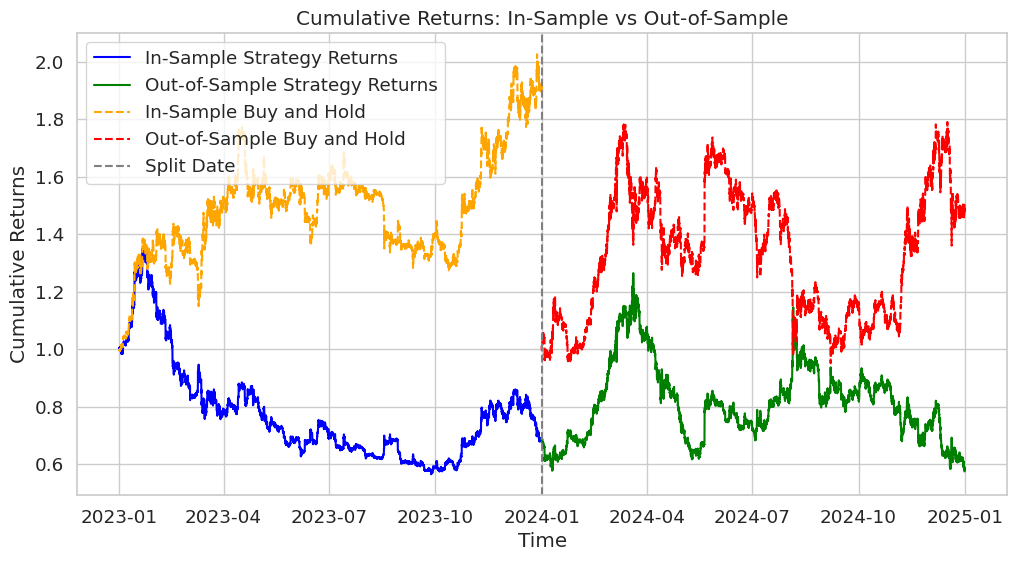

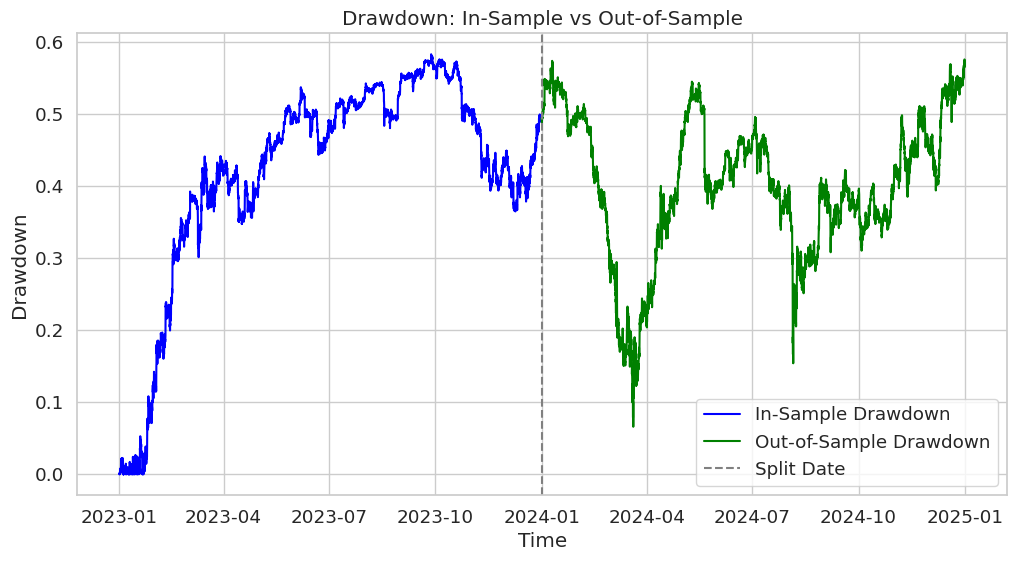

In [7]:
# Convert split_date to a datetime object
split_date = pd.to_datetime('2024-01-01')

# Split the data into in-sample and out-of-sample
in_sample = df.loc[:split_date].copy()  # Use .copy() to avoid SettingWithCopyWarning
out_of_sample = df.loc[split_date:].copy()

# Calculate cumulative returns for in-sample and out-of-sample
in_sample_cumulative_return = in_sample['cumulative_returns'].iloc[-1]
out_of_sample_cumulative_return = out_of_sample['cumulative_returns'].iloc[-1]

# Calculate annualized returns for in-sample and out-of-sample
def annualized_return(cumulative_return, num_periods):
    return (1 + cumulative_return) ** (365 * 24 / num_periods) - 1  # Assuming hourly data

in_sample_annualized_return = annualized_return(in_sample_cumulative_return - 1, len(in_sample))
out_of_sample_annualized_return = annualized_return(out_of_sample_cumulative_return - 1, len(out_of_sample))

# Calculate max drawdown for in-sample and out-of-sample
def calculate_max_drawdown(cumulative_returns):
    cumulative_max = cumulative_returns.cummax()
    drawdown = 1 - cumulative_returns / cumulative_max
    return drawdown.max()

in_sample_max_drawdown = calculate_max_drawdown(in_sample['cumulative_returns'])
out_of_sample_max_drawdown = calculate_max_drawdown(out_of_sample['cumulative_returns'])

# Print out-of-sample testing results
print("=== Out-of-Sample Testing ===")
print(f"In-Sample Cumulative Returns: {in_sample_cumulative_return:.2f}")
print(f"Out-of-Sample Cumulative Returns: {out_of_sample_cumulative_return:.2f}")
print(f"In-Sample Annualized Return: {in_sample_annualized_return:.2%}")
print(f"Out-of-Sample Annualized Return: {out_of_sample_annualized_return:.2%}")
print(f"In-Sample Max Drawdown: {in_sample_max_drawdown:.2%}")
print(f"Out-of-Sample Max Drawdown: {out_of_sample_max_drawdown:.2%}")
print("\n")

# Plot cumulative returns for in-sample and out-of-sample
plt.figure(figsize=(12, 6))
plt.plot(in_sample['cumulative_returns'], label='In-Sample Strategy Returns', color='blue')
plt.plot(out_of_sample['cumulative_returns'], label='Out-of-Sample Strategy Returns', color='green')
plt.plot((1 + in_sample['returns']).cumprod(), label='In-Sample Buy and Hold', color='orange', linestyle='--')
plt.plot((1 + out_of_sample['returns']).cumprod(), label='Out-of-Sample Buy and Hold', color='red', linestyle='--')
plt.axvline(x=split_date, color='gray', linestyle='--', label='Split Date')
plt.title('Cumulative Returns: In-Sample vs Out-of-Sample')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Plot drawdown for in-sample and out-of-sample
plt.figure(figsize=(12, 6))
plt.plot(in_sample['drawdown'], label='In-Sample Drawdown', color='blue')
plt.plot(out_of_sample['drawdown'], label='Out-of-Sample Drawdown', color='green')
plt.axvline(x=split_date, color='gray', linestyle='--', label='Split Date')
plt.title('Drawdown: In-Sample vs Out-of-Sample')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

2. Walk-Forward Analysis

/tmp/ipykernel_1321/4283439054.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for start in pd.date_range(start=df.index[0], end=df.index[-1], freq=window_size):


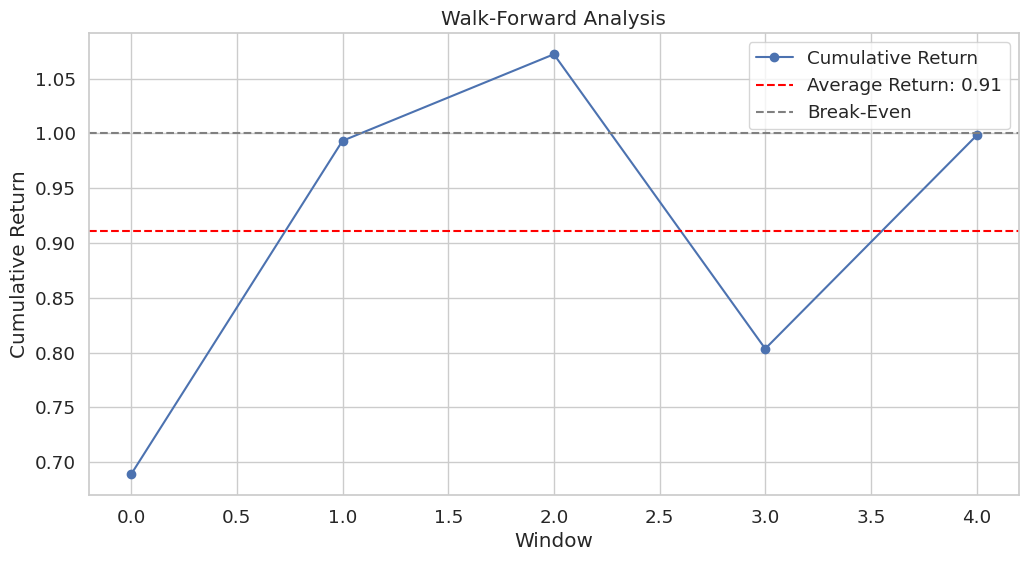

=== Walk-Forward Analysis ===
Average Cumulative Return: 0.91
Median Cumulative Return: 0.99
Standard Deviation of Returns: 0.16
Minimum Cumulative Return: 0.69
Maximum Cumulative Return: 1.07




In [8]:
# Define the window size for walk-forward analysis
window_size = '6M'  # 6-month windows
walk_forward_results = []

# Perform walk-forward analysis
for start in pd.date_range(start=df.index[0], end=df.index[-1], freq=window_size):
    end = start + pd.DateOffset(months=6)  # Define the end of the window
    window_data = df.loc[start:end]  # Extract data for the current window
    
    # Skip if the window is empty
    if not window_data.empty:
        # Calculate cumulative returns for the current window
        cumulative_return = (1 + window_data['strategy_returns']).cumprod().iloc[-1]
        walk_forward_results.append(cumulative_return)

# Convert results to a DataFrame for easier analysis
walk_forward_results_df = pd.DataFrame(walk_forward_results, columns=['Cumulative Return'])

# Calculate additional metrics
average_return = walk_forward_results_df['Cumulative Return'].mean()
median_return = walk_forward_results_df['Cumulative Return'].median()
std_return = walk_forward_results_df['Cumulative Return'].std()
min_return = walk_forward_results_df['Cumulative Return'].min()
max_return = walk_forward_results_df['Cumulative Return'].max()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(walk_forward_results_df['Cumulative Return'], marker='o', label='Cumulative Return')
plt.axhline(y=average_return, color='red', linestyle='--', label=f'Average Return: {average_return:.2f}')
plt.axhline(y=1, color='gray', linestyle='--', label='Break-Even')
plt.title('Walk-Forward Analysis')
plt.xlabel('Window')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Print walk-forward analysis results
print("=== Walk-Forward Analysis ===")
print(f"Average Cumulative Return: {average_return:.2f}")
print(f"Median Cumulative Return: {median_return:.2f}")
print(f"Standard Deviation of Returns: {std_return:.2f}")
print(f"Minimum Cumulative Return: {min_return:.2f}")
print(f"Maximum Cumulative Return: {max_return:.2f}")
print("\n")

3. Monte Carlo Simulation

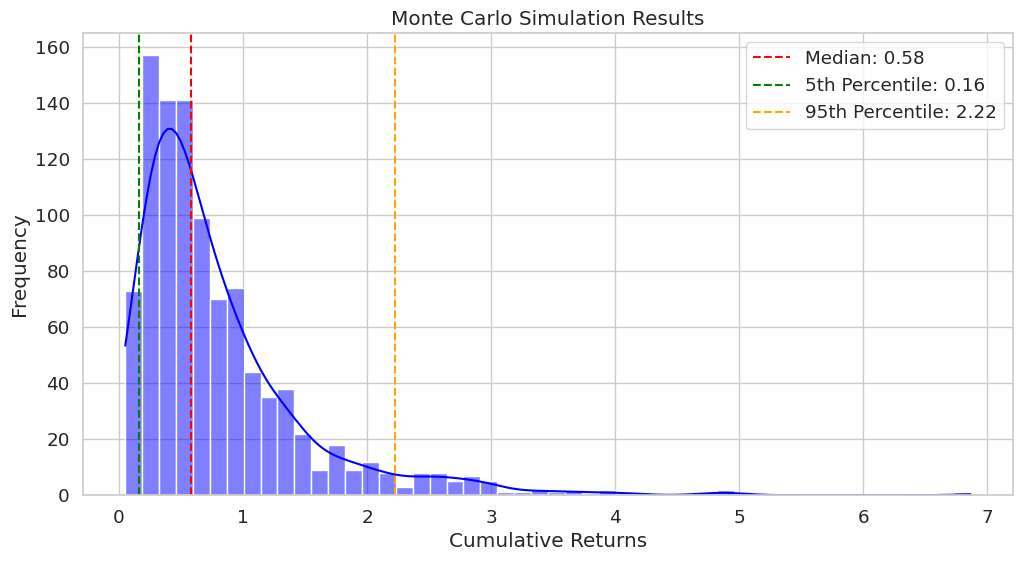

=== Monte Carlo Simulation ===
Median Simulated Returns: 0.58
5th Percentile Returns: 0.16
95th Percentile Returns: 2.22
Standard Deviation of Returns: 0.71




In [9]:
# Define the number of simulations
num_simulations = 1000
simulation_results = []

# Perform Monte Carlo simulation
for _ in range(num_simulations):
    # Shuffle the strategy returns (with replacement)
    shuffled_returns = np.random.choice(df['strategy_returns'].dropna(), size=len(df['strategy_returns'].dropna()), replace=True)
    
    # Convert the shuffled returns to a Pandas Series
    shuffled_returns_series = pd.Series(shuffled_returns)
    
    # Calculate cumulative returns for the shuffled series
    cumulative_return = (1 + shuffled_returns_series).cumprod().iloc[-1]
    simulation_results.append(cumulative_return)

# Convert results to a DataFrame for easier analysis
simulation_results_df = pd.DataFrame(simulation_results, columns=['Cumulative Return'])

# Plot results
plt.figure(figsize=(12, 6))
sns.histplot(simulation_results_df['Cumulative Return'], bins=50, kde=True, color='blue')
plt.axvline(x=np.median(simulation_results), color='red', linestyle='--', label=f'Median: {np.median(simulation_results):.2f}')
plt.axvline(x=np.percentile(simulation_results, 5), color='green', linestyle='--', label=f'5th Percentile: {np.percentile(simulation_results, 5):.2f}')
plt.axvline(x=np.percentile(simulation_results, 95), color='orange', linestyle='--', label=f'95th Percentile: {np.percentile(simulation_results, 95):.2f}')
plt.title('Monte Carlo Simulation Results')
plt.xlabel('Cumulative Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print Monte Carlo simulation results
print("=== Monte Carlo Simulation ===")
print(f"Median Simulated Returns: {np.median(simulation_results):.2f}")
print(f"5th Percentile Returns: {np.percentile(simulation_results, 5):.2f}")
print(f"95th Percentile Returns: {np.percentile(simulation_results, 95):.2f}")
print(f"Standard Deviation of Returns: {np.std(simulation_results):.2f}")
print("\n")

4. Stress Testing

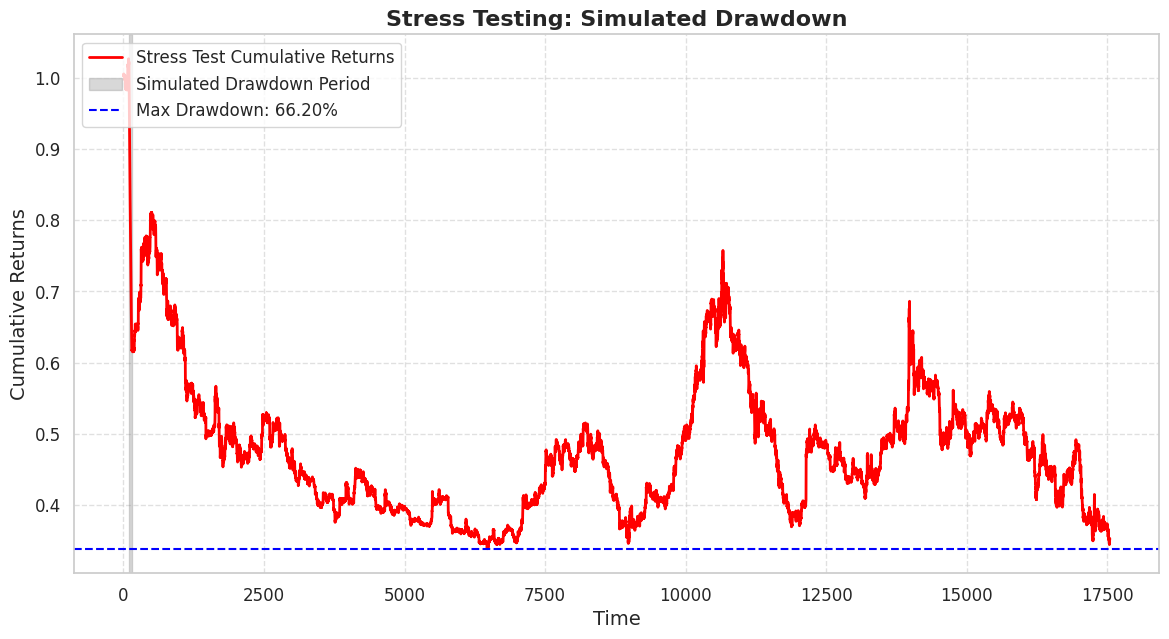

=== Stress Testing ===
Max Drawdown: 66.20%
Recovery Period: 11075 periods




In [10]:
# Copy the strategy returns for stress testing
stress_returns = df['strategy_returns'].copy()

# Simulate a drawdown by reducing returns for a specific period
stress_returns.iloc[100:150] = -0.01  # Simulate a 1% daily loss for 50 periods

# Calculate cumulative returns under stress
stress_cumulative = (1 + stress_returns).cumprod()

# Ensure the cumulative returns start from the leftmost side
stress_cumulative = stress_cumulative.reset_index(drop=True)  # Reset index to ensure alignment

# Calculate key metrics
max_drawdown = 1 - stress_cumulative.min()  # Max drawdown
drawdown_end_index = stress_cumulative.idxmin()  # Index of the lowest point
recovery_period = len(stress_cumulative.loc[drawdown_end_index:])  # Recovery period

# Plot results with clearer visualization
plt.figure(figsize=(14, 7))
plt.plot(stress_cumulative, color='red', label='Stress Test Cumulative Returns', linewidth=2)
plt.axvspan(100, 150, color='gray', alpha=0.3, label='Simulated Drawdown Period')
plt.axhline(y=stress_cumulative.min(), color='blue', linestyle='--', label=f'Max Drawdown: {max_drawdown:.2%}')
plt.title('Stress Testing: Simulated Drawdown', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper left')
plt.show()

# Print stress testing results
print("=== Stress Testing ===")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Recovery Period: {recovery_period} periods")
print("\n")

5. Sensitivity Analysis

=== Sensitivity Analysis ===
SMA 30 Cumulative Returns: 1.95
SMA 50 Cumulative Returns: 0.59
SMA 100 Cumulative Returns: 0.62




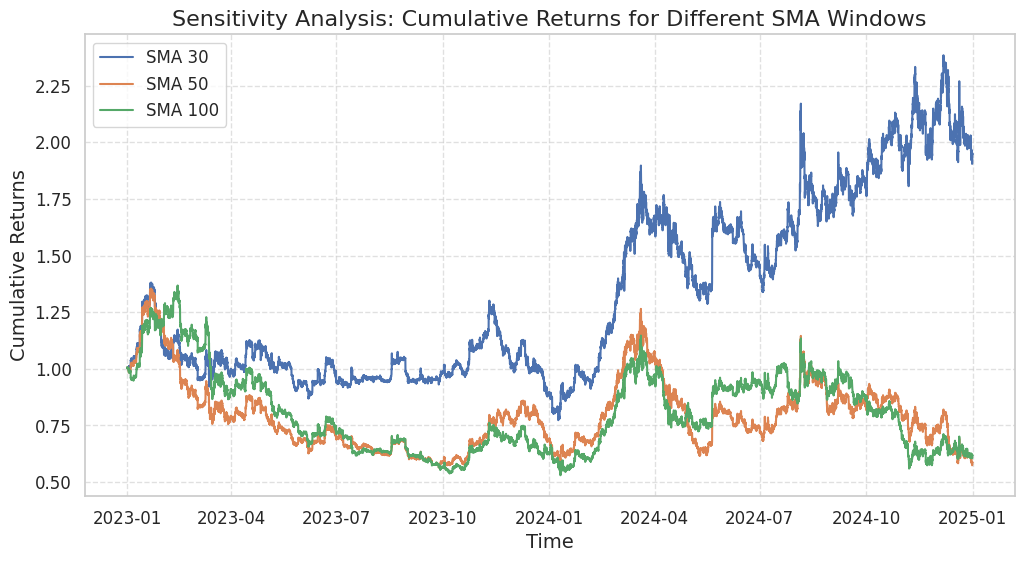

In [11]:
import numpy as np
import pandas as pd

# Define SMA windows to test
sma_windows = [30, 50, 100]
sensitivity_results = {}

# Perform sensitivity analysis
for window in sma_windows:
    # Calculate SMA and generate signals
    df[f'SMA_{window}'] = df['close'].rolling(window=window, min_periods=1).mean()
    df[f'signal_{window}'] = np.where(df[f'SMA_{window}'] > df['SMA_200'], 1, -1)
    
    # Calculate strategy returns
    df[f'strategy_returns_{window}'] = df[f'signal_{window}'].shift(1) * df['returns']
    
    # Calculate cumulative returns
    sensitivity_results[window] = (1 + df[f'strategy_returns_{window}']).cumprod().iloc[-1]

# Print sensitivity analysis results
print("=== Sensitivity Analysis ===")
for window, returns in sensitivity_results.items():
    print(f"SMA {window} Cumulative Returns: {returns:.2f}")
print("\n")

# Plot sensitivity analysis results
plt.figure(figsize=(12, 6))
for window in sma_windows:
    plt.plot((1 + df[f'strategy_returns_{window}']).cumprod(), label=f'SMA {window}')
plt.title('Sensitivity Analysis: Cumulative Returns for Different SMA Windows', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper left')
plt.show()

6. Transaction Cost Analysis


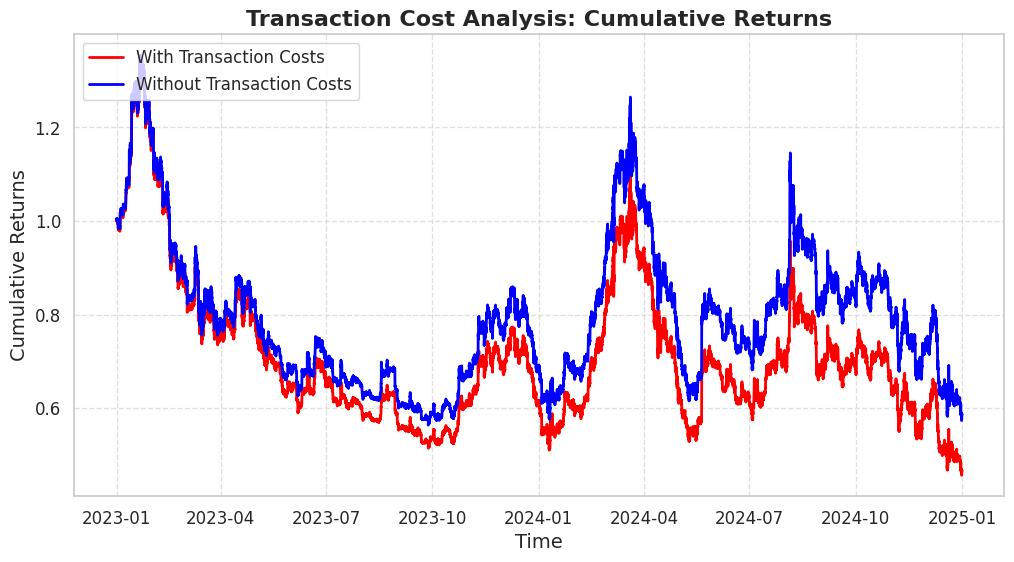

=== Transaction Cost Analysis ===
Returns Without Costs: 0.59
Returns With Costs: 0.47
Impact of Costs: 0.12




In [12]:
# Define transaction cost
transaction_cost = 0.001  # 0.1% per trade

# Calculate strategy returns with transaction costs
df['strategy_returns_with_cost'] = df['strategy_returns'] - transaction_cost * abs(df['signal'].diff())

# Calculate cumulative returns with and without costs
df['cumulative_returns_with_cost'] = (1 + df['strategy_returns_with_cost']).cumprod()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df['cumulative_returns_with_cost'], label='With Transaction Costs', color='red', linewidth=2)
plt.plot(df['cumulative_returns'], label='Without Transaction Costs', color='blue', linewidth=2)
plt.title('Transaction Cost Analysis: Cumulative Returns', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper left')
plt.show()

# Print transaction cost analysis results
print("=== Transaction Cost Analysis ===")
print(f"Returns Without Costs: {df['cumulative_returns'].iloc[-1]:.2f}")
print(f"Returns With Costs: {df['cumulative_returns_with_cost'].iloc[-1]:.2f}")
print(f"Impact of Costs: {df['cumulative_returns'].iloc[-1] - df['cumulative_returns_with_cost'].iloc[-1]:.2f}")
print("\n")

7. Statistical Significance Testing

In [13]:
# Perform statistical significance testing
t_stat, p_value = ttest_1samp(df['strategy_returns'].dropna(), 0)

# Print results
print("=== Statistical Significance Testing ===")
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Returns are statistically significant (p < 0.05).")
else:
    print("Returns are not statistically significant (p >= 0.05).")
print("\n")

# Additional analysis: Confidence interval for mean returns
from scipy.stats import t
mean_returns = df['strategy_returns'].mean()
std_returns = df['strategy_returns'].std()
n = len(df['strategy_returns'].dropna())
confidence_level = 0.95
degrees_freedom = n - 1
t_critical = t.ppf((1 + confidence_level) / 2, degrees_freedom)
margin_of_error = t_critical * (std_returns / np.sqrt(n))
confidence_interval = (mean_returns - margin_of_error, mean_returns + margin_of_error)

print("=== Additional Analysis ===")
print(f"Mean Returns: {mean_returns:.4f}")
print(f"95% Confidence Interval for Mean Returns: ({confidence_interval[0]:.4f}, {confidence_interval[1]:.4f})")
print("\n")

=== Statistical Significance Testing ===
T-statistic: -0.28, P-value: 0.7798
Returns are not statistically significant (p >= 0.05).


=== Additional Analysis ===
Mean Returns: -0.0000
95% Confidence Interval for Mean Returns: (-0.0001, 0.0001)




# Step 7: Advanced Analysis Techniques

1. Parameter Optimization with Cross-Validation

=== Parameter Optimization ===
Best Parameters: {'sma_long': 100, 'sma_short': 30}, Best Returns: 2.14




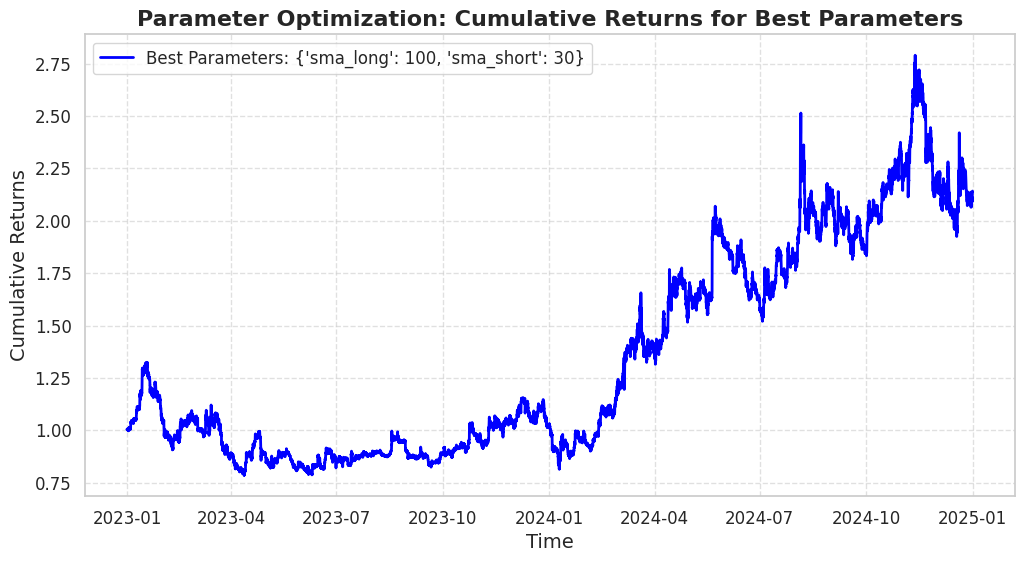

In [14]:
# Define parameter grid
param_grid = {
    'sma_short': [30, 50, 100],
    'sma_long': [100, 200, 300]
}

# Store results
results = []

# Perform parameter optimization
for params in ParameterGrid(param_grid):
    # Calculate SMAs and generate signals
    df['SMA_short'] = df['close'].rolling(window=params['sma_short'], min_periods=1).mean()
    df['SMA_long'] = df['close'].rolling(window=params['sma_long'], min_periods=1).mean()
    df['signal'] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
    
    # Calculate strategy returns
    df['strategy_returns'] = df['signal'].shift(1) * df['returns']
    
    # Calculate cumulative returns
    cumulative_returns = (1 + df['strategy_returns']).cumprod().iloc[-1]
    results.append((params, cumulative_returns))

# Find best parameters
best_params, best_returns = max(results, key=lambda x: x[1])

# Print parameter optimization results
print("=== Parameter Optimization ===")
print(f"Best Parameters: {best_params}, Best Returns: {best_returns:.2f}")
print("\n")

# Plot cumulative returns for the best parameters
df['SMA_short'] = df['close'].rolling(window=best_params['sma_short'], min_periods=1).mean()
df['SMA_long'] = df['close'].rolling(window=best_params['sma_long'], min_periods=1).mean()
df['signal'] = np.where(df['SMA_short'] > df['SMA_long'], 1, -1)
df['strategy_returns'] = df['signal'].shift(1) * df['returns']
df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df['cumulative_returns'], label=f"Best Parameters: {best_params}", color='blue', linewidth=2)
plt.title('Parameter Optimization: Cumulative Returns for Best Parameters', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper left')
plt.show()

2. Regime Detection


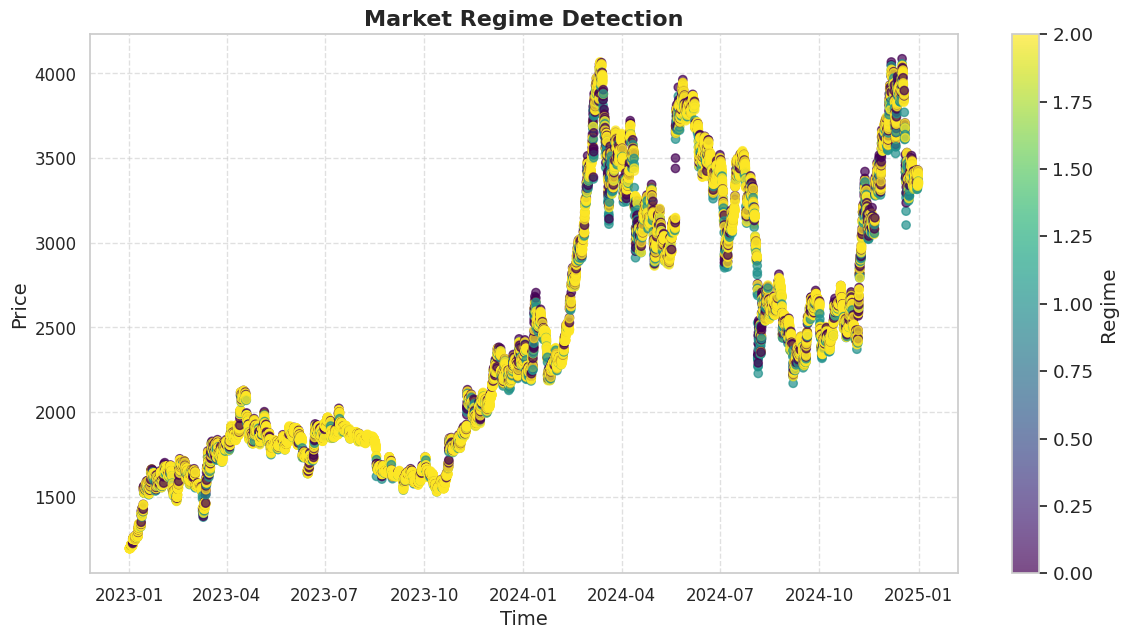

=== Regime Analysis ===
Regime 0 Cumulative Returns: 2.44
Regime 0 Annualized Returns: 5101.51%
Regime 1 Cumulative Returns: 1.79
Regime 1 Annualized Returns: 21249.20%
Regime 2 Cumulative Returns: 0.49
Regime 2 Annualized Returns: 30.37%




In [15]:
# Regime Detection
df['volatility'] = df['returns'].rolling(window=50, min_periods=1).std()
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

# Drop NaN values from features
features = df[['volatility', 'log_returns']].dropna()

# Cluster into 3 regimes
kmeans = KMeans(n_clusters=3, random_state=42)
regime_labels = kmeans.fit_predict(features)

# Align regime labels with the original DataFrame
df['regime'] = np.nan  # Initialize with NaN
df.loc[features.index, 'regime'] = regime_labels  # Assign labels to matching rows

# Plot regimes
plt.figure(figsize=(14, 7))
plt.scatter(df.index, df['close'], c=df['regime'], cmap='viridis', alpha=0.7)
plt.title('Market Regime Detection', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar(label='Regime')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Evaluate strategy performance by regime
print("=== Regime Analysis ===")
for regime in range(3):
    regime_returns = df[df['regime'] == regime]['strategy_returns']
    if not regime_returns.empty:
        cumulative_returns = (1 + regime_returns).cumprod().iloc[-1]
        annualized_return = (1 + cumulative_returns) ** (365 * 24 / len(regime_returns)) - 1  # Assuming hourly data
        print(f"Regime {regime} Cumulative Returns: {cumulative_returns:.2f}")
        print(f"Regime {regime} Annualized Returns: {annualized_return:.2%}")
print("\n")

3. Risk-Adjusted Performance Metrics

In [16]:
# Calculate annualized return
annualized_return = df['strategy_returns'].mean() * 365 * 24  # Assuming hourly data

# Calculate Calmar Ratio
calmar_ratio = annualized_return / max_drawdown

# Calculate Omega Ratio
threshold = 0
gains = df['strategy_returns'][df['strategy_returns'] > threshold].sum()
losses = -df['strategy_returns'][df['strategy_returns'] < threshold].sum()
omega_ratio = gains / losses if losses != 0 else np.nan  # Handle division by zero

# Calculate Tail Ratio
tail_ratio = np.percentile(df['strategy_returns'], 95) / np.percentile(df['strategy_returns'], 5) if np.percentile(df['strategy_returns'], 5) != 0 else np.nan  # Handle division by zero

# Print risk-adjusted metrics
print("=== Risk-Adjusted Metrics ===")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Omega Ratio: {omega_ratio:.2f}")
print(f"Tail Ratio: {tail_ratio:.2f}")
print("\n")

=== Risk-Adjusted Metrics ===
Annualized Return: 53.50%
Calmar Ratio: 0.81
Omega Ratio: 1.03
Tail Ratio: nan




4. Bootstrap Analysis

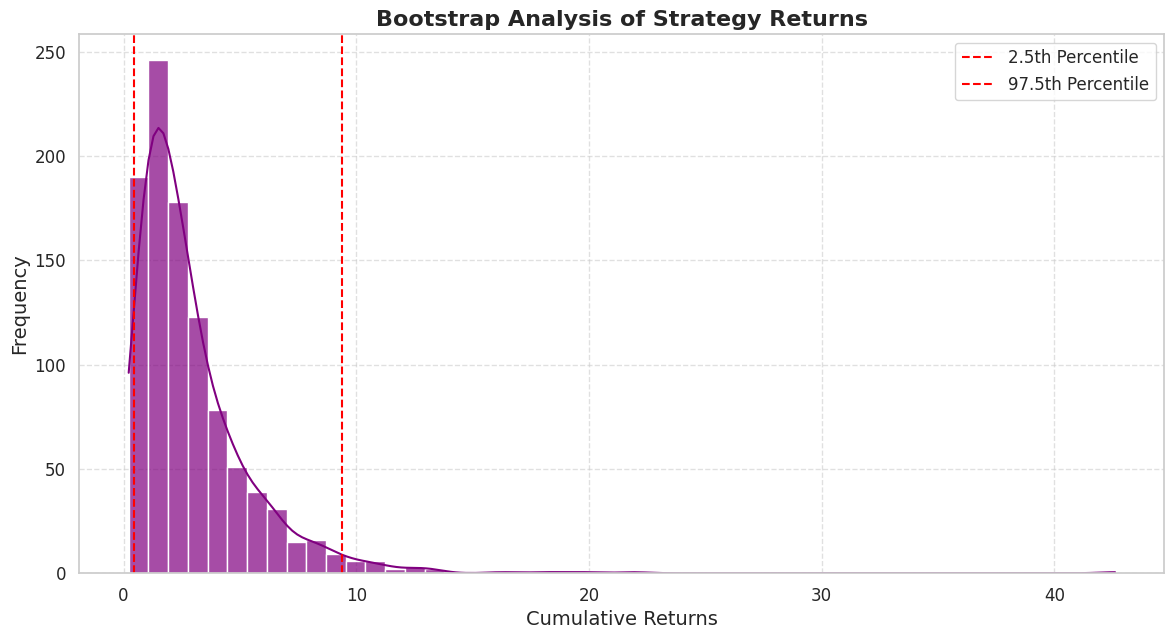

=== Bootstrap Analysis ===
Mean Cumulative Returns: 2.95
Median Cumulative Returns: 2.22
95% Confidence Interval: [0.44, 9.39]




In [17]:
# Define the number of bootstrap samples
num_bootstrap_samples = 1000
bootstrap_results = []

# Perform bootstrap analysis
for _ in range(num_bootstrap_samples):
    # Resample the strategy returns with replacement
    sample_returns = np.random.choice(df['strategy_returns'].dropna(), size=len(df), replace=True)
    
    # Calculate cumulative returns for the resampled data
    cumulative_returns = (1 + sample_returns).cumprod()
    bootstrap_results.append(cumulative_returns[-1])  # Append the final cumulative return

# Plot bootstrap results
plt.figure(figsize=(14, 7))
sns.histplot(bootstrap_results, bins=50, kde=True, color='purple', alpha=0.7)
plt.axvline(x=np.percentile(bootstrap_results, 2.5), color='red', linestyle='--', label='2.5th Percentile')
plt.axvline(x=np.percentile(bootstrap_results, 97.5), color='red', linestyle='--', label='97.5th Percentile')
plt.title('Bootstrap Analysis of Strategy Returns', fontsize=16, fontweight='bold')
plt.xlabel('Cumulative Returns', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

# Print confidence intervals and additional metrics
print("=== Bootstrap Analysis ===")
print(f"Mean Cumulative Returns: {np.mean(bootstrap_results):.2f}")
print(f"Median Cumulative Returns: {np.median(bootstrap_results):.2f}")
print(f"95% Confidence Interval: [{np.percentile(bootstrap_results, 2.5):.2f}, {np.percentile(bootstrap_results, 97.5):.2f}]")
print("\n")

5. Event-Driven Analysis


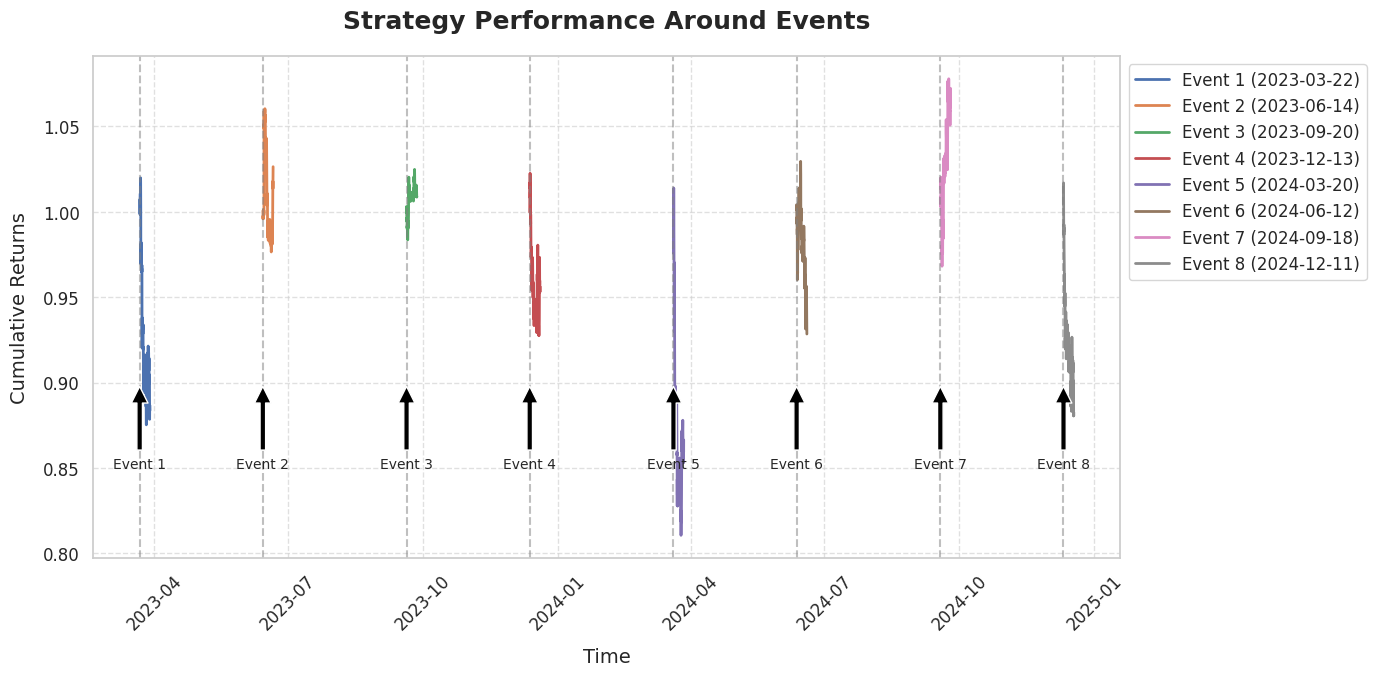

In [18]:
# Define event dates
event_dates = [
    '2023-03-22', '2023-06-14', '2023-09-20', '2023-12-13',
    '2024-03-20', '2024-06-12', '2024-09-18', '2024-12-11'
]

# Extract event windows
event_windows = []
for date in event_dates:
    event_window = df.loc[date:pd.to_datetime(date) + pd.Timedelta(days=7)]['strategy_returns']
    event_windows.append(event_window)

# Plot event-driven returns
plt.figure(figsize=(14, 7))

# Plot each event window
for i, window in enumerate(event_windows):
    plt.plot((1 + window).cumprod(), label=f"Event {i+1} ({window.index[0].date()})", linewidth=2)

# Add vertical lines for event dates
for date in event_dates:
    plt.axvline(x=pd.to_datetime(date), color='gray', linestyle='--', alpha=0.5)

# Add title and labels
plt.title('Strategy Performance Around Events', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=14, labelpad=10)
plt.ylabel('Cumulative Returns', fontsize=14, labelpad=10)

# Improve tick formatting
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot

# Add annotations for key events
for i, date in enumerate(event_dates):
    plt.annotate(f"Event {i+1}", xy=(pd.to_datetime(date), 0.9), xytext=(pd.to_datetime(date), 0.85),
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, ha='center')

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


6. Machine Learning for Signal Enhancement


In [19]:
# Add feature engineering
df['rolling_mean_20'] = df['returns'].rolling(window=20).mean()
df['RSI'] = RSIIndicator(close=df['close'], window=14).rsi()
df['momentum'] = df['close'].diff()
df.dropna(inplace=True)

# Prepare target variable
df['target'] = np.where(df['returns'].shift(-1) > 0, 1, 0)

# Prepare features and target
features = df[['SMA_50', 'SMA_200', 'returns', 'volatility', 'rolling_mean_20', 'RSI', 'momentum']]
target = df['target']

# Time-based train-test split to avoid look-ahead bias
split_date = df.index[int(0.8 * len(df))]
X_train = features[features.index < split_date]
X_test = features[features.index >= split_date]
y_train = target[features.index < split_date]
y_test = target[features.index >= split_date]

# Create a pipeline with scaling and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("=== Machine Learning Model ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Add ML signals to strategy
df['ml_signal'] = np.nan
df.loc[X_test.index, 'ml_signal'] = y_prob  # Use probabilities instead of binary predictions

# Combine signals using probability thresholds
buy_threshold = 0.6
sell_threshold = 0.4
df['combined_signal'] = np.where((df['signal'] == 1) & (df['ml_signal'] > buy_threshold), 1,
                                  np.where((df['signal'] == -1) & (df['ml_signal'] < sell_threshold), -1, 0))
df['combined_returns'] = df['combined_signal'].shift(1) * df['returns']

# Evaluate strategy performance
strategy_cum_returns = (1 + df['combined_returns']).cumprod()
sharpe_ratio = df['combined_returns'].mean() / df['combined_returns'].std()

print(f"Combined Strategy Returns: {strategy_cum_returns.iloc[-1]:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

=== Machine Learning Model ===
Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Model Accuracy: 0.53

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.48      0.50      1736
           1       0.53      0.59      0.56      1769

    accuracy                           0.53      3505
   macro avg       0.53      0.53      0.53      3505
weighted avg       0.53      0.53      0.53      3505


Confusion Matrix:
[[ 825  911]
 [ 726 1043]]
Combined Strategy Returns: 1.09
Sharpe Ratio: 0.01
